# Import all required libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Read all data into Pandas DataFrames

In [2]:
def process_feature_file(file_path: str, feature_name: str) -> pd.DataFrame:
    """
    Process a single feature file into a DataFrame row with month_year columns.
    
    Args:
        file_path: Path to the CSV file.
        feature_name: Name of the feature (used as the row index).
    
    Returns:
        DataFrame with 1 row and columns like 'jan_1999', 'feb_1999', etc.
    """
    # Define dtype mapping for all monthly columns
    month_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 
                    'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    
    dtype_mapping = {col: float for col in month_columns}
    dtype_mapping['Year'] = int  # Keep Year as integer

    # Read CSV with explicit dtype specification
    df = pd.read_csv(file_path, dtype=dtype_mapping)
    
    # Rest of processing remains the same...
    feature_data = pd.DataFrame()
    
    for _, row in df.iterrows():
        year = int(row['Year'])
        monthly_values = row[month_columns]  # Explicit column selection
        
        # Create month_year column names
        month_year_columns = {
            month: f"{month.lower().strip()}_{year}"
            for month in monthly_values.index
        }
        
        year_df = pd.DataFrame([monthly_values.values], 
                              columns=month_year_columns.values())
        feature_data = pd.concat([feature_data, year_df], axis=1)
    
    feature_data.index = [feature_name]
    return feature_data

# List of tuples (file_path, feature_name)
DATA_PATH = '../data/wales/'
files_to_process = [
    (DATA_PATH+'wales_airfrost_days.csv', 'airfrost_days'),
    (DATA_PATH+'wales_precipitation_per_month.csv', 'rainfall'), 
    (DATA_PATH+'wales_monthly_temp.csv', 'temperature'),
    (DATA_PATH+'wales_monthly_sunshine.csv', 'sunshine')
]

# Process all files
dataframes = []
all_columns = set()  # Track all possible columns

for file_path, feature in files_to_process:
    df = process_feature_file(file_path, feature)
    all_columns.update(df.columns)
    dataframes.append(df)

weather_data_df = pd.concat(dataframes)
print(weather_data_df)


               jan_1999  feb_1999  mar_1999  apr_1999  may_1999  jun_1999  \
airfrost_days       6.6       6.1       3.2       4.3       0.0       0.1   
rainfall          250.9     104.0     100.2     122.5      83.4      84.8   
temperature         5.2       4.9       6.4       8.5      11.8      12.5   
sunshine           43.9      53.7      91.9     144.8     131.9     173.3   

               jul_1999  aug_1999  sep_1999  oct_1999  ...  mar_2024  \
airfrost_days       0.0       0.0       0.0       0.4  ...       4.2   
rainfall           28.0     138.0     204.3     137.4  ...     158.2   
temperature        16.2      15.1      14.0      10.0  ...       7.0   
sunshine          226.4     144.9     149.1     109.1  ...      86.8   

               apr_2024  may_2024  jun_2024  jul_2024  aug_2024  sep_2024  \
airfrost_days       2.0       0.0       0.0       0.0       0.0       0.1   
rainfall          135.8      95.4      48.1      88.7     103.5     155.2   
temperature         8.

# Test for stationarity using ACF method

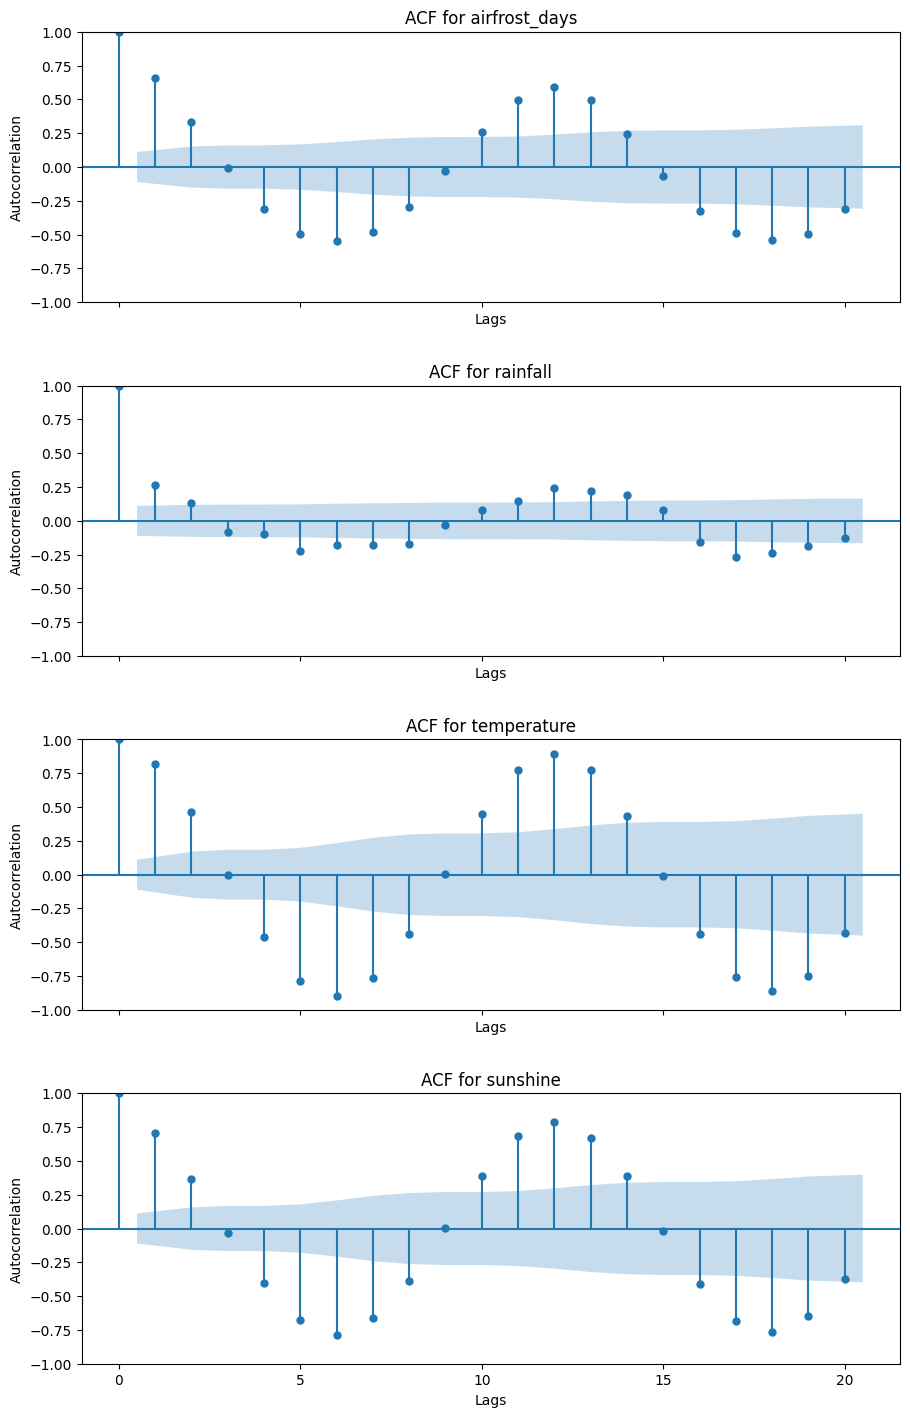

In [13]:
def create_stationarity_plots_using_acf(input_df):
    # Assuming `final_df` is already created and contains the data
    # Transpose the DataFrame to have time as rows and features as columns
    data = input_df.T

    # Plot ACF for each feature
    fig, axes = plt.subplots(len(data.columns), 1, figsize=(10, 15), sharex=True)
    fig.tight_layout(pad=5.0)

    for i, feature in enumerate(data.columns):
        plot_acf(data[feature], ax=axes[i], lags=20)  # Limit lags to 20 for clarity
        axes[i].set_title(f"ACF for {feature}")
        axes[i].set_xlabel("Lags")
        axes[i].set_ylabel("Autocorrelation")

    plt.show()

# Now run the stationarity plots
create_stationarity_plots_using_acf(weather_data_df)

# Plot the input data to visually inspect for trends

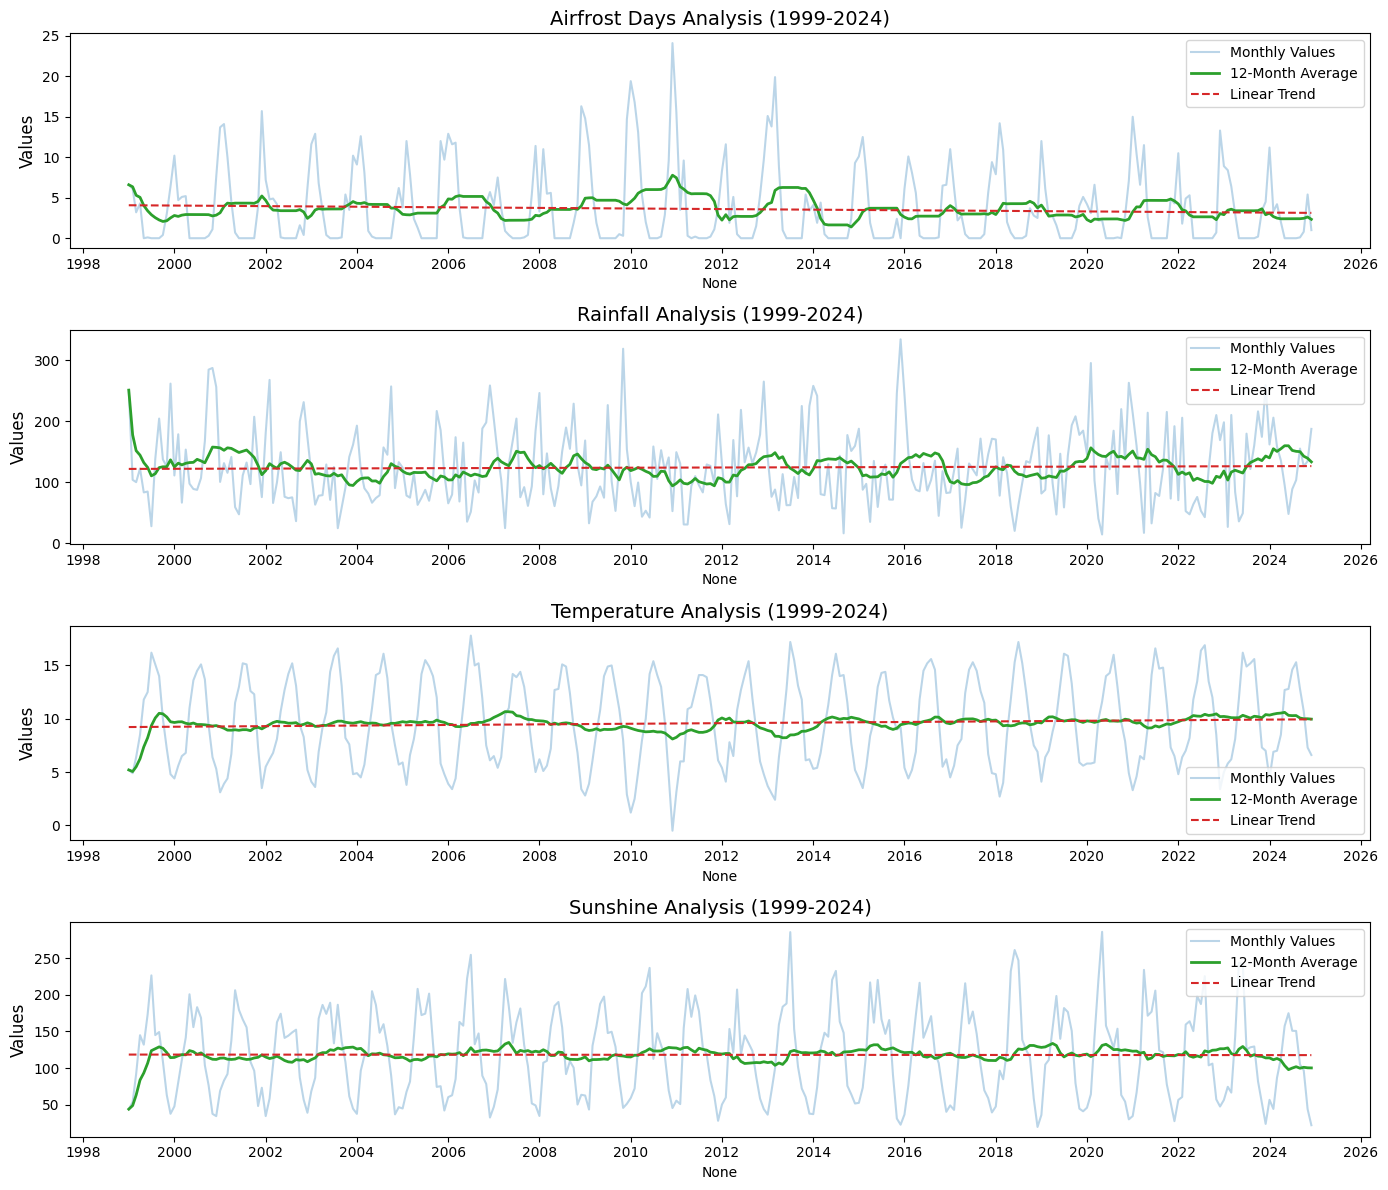

In [14]:
# Create plotting function
def plot_feature_with_analysis(series, feature_name, ax):
    dates = pd.to_datetime(series.index, format='%b_%Y')
    values = series.values.astype(float)
    ts = pd.Series(values, index=dates)
    
    # Calculate components
    rolling_avg = ts.rolling(window=12, min_periods=1).mean()
    ordinal_dates = ts.index.map(pd.Timestamp.toordinal)
    z = np.polyfit(ordinal_dates, values, 1)
    trend_line = np.poly1d(z)(ordinal_dates)

    # Plotting
    sns.lineplot(x=ts.index, y=ts.values, ax=ax, color='#1f77b4', alpha=0.3, label='Monthly Values')
    sns.lineplot(x=rolling_avg.index, y=rolling_avg, ax=ax, color='#2ca02c', linewidth=2, label='12-Month Average')
    sns.lineplot(x=ts.index, y=trend_line, ax=ax, color='#d62728', linestyle='--', label='Linear Trend')
    
    # Formatting
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_title(f'{feature_name.replace("_", " ").title()} Analysis (1999-2024)', fontsize=14)
    ax.set_ylabel('Values', fontsize=12)
    ax.legend()

# 3. Generate plots
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
for idx, (feature, data) in enumerate(weather_data_df.iterrows()):
    plot_feature_with_analysis(data, feature, axes[idx])

plt.tight_layout()
plt.show()

# Apply smoothing to the input data

1999-01-01    6.6
1999-02-01    6.1
1999-03-01    3.2
1999-04-01    4.3
1999-05-01    0.0
             ... 
2024-08-01    0.0
2024-09-01    0.1
2024-10-01    0.8
2024-11-01    5.4
2024-12-01    1.0
Length: 312, dtype: float64


/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


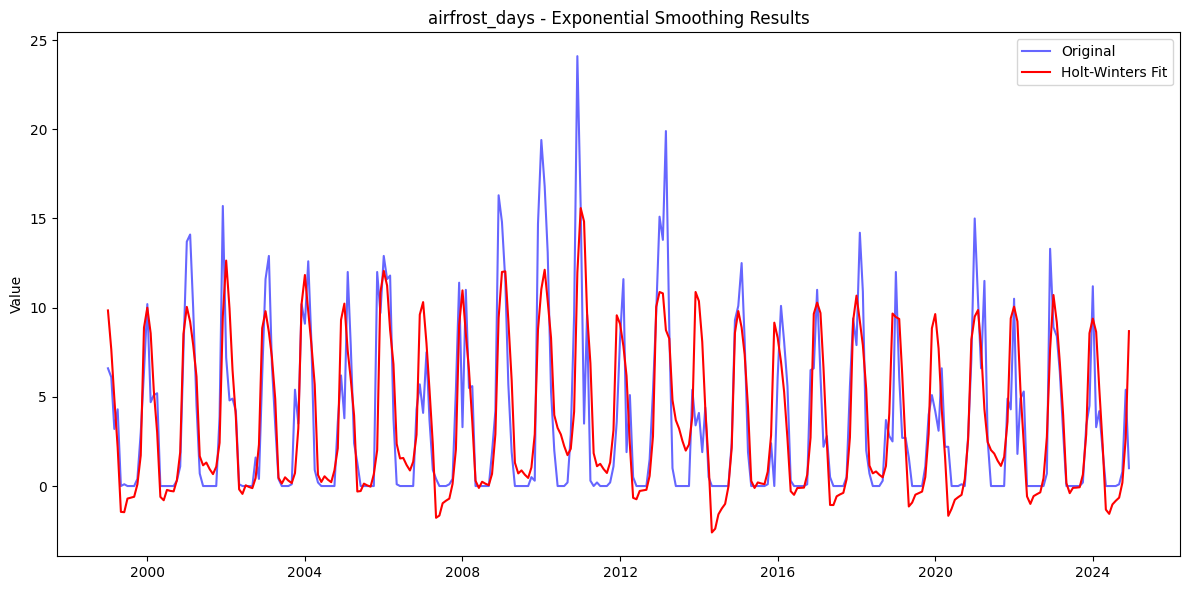


Model Summary for airfrost_days:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                           2566.488
Optimized:                         True   AIC                            689.475
Trend:                         Additive   BIC                            749.363
Seasonal:                      Additive   AICC                           691.809
Seasonal Periods:                    12   Date:                 Sun, 09 Mar 2025
Box-Cox:                          False   Time:                         17:53:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2073309                alpha             

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


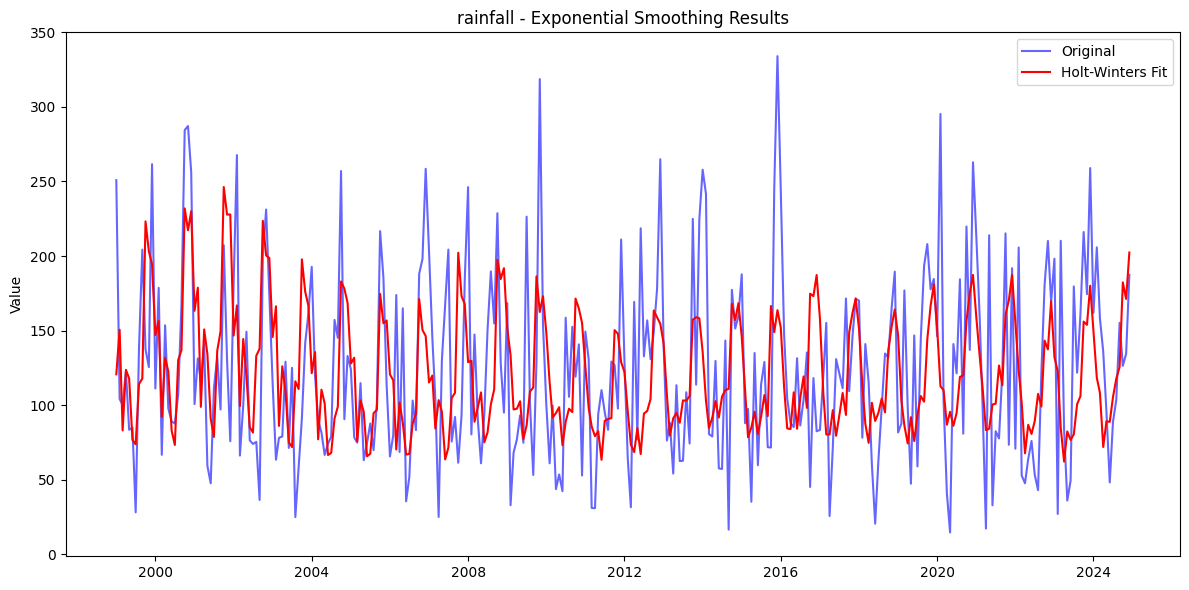


Model Summary for rainfall:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                        1019484.254
Optimized:                         True   AIC                           2556.643
Trend:                         Additive   BIC                           2616.531
Seasonal:                Multiplicative   AICC                          2558.977
Seasonal Periods:                    12   Date:                 Sun, 09 Mar 2025
Box-Cox:                           True   Time:                         17:53:11
Box-Cox Coeff.:                 0.43089                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0452382                alpha                 T

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


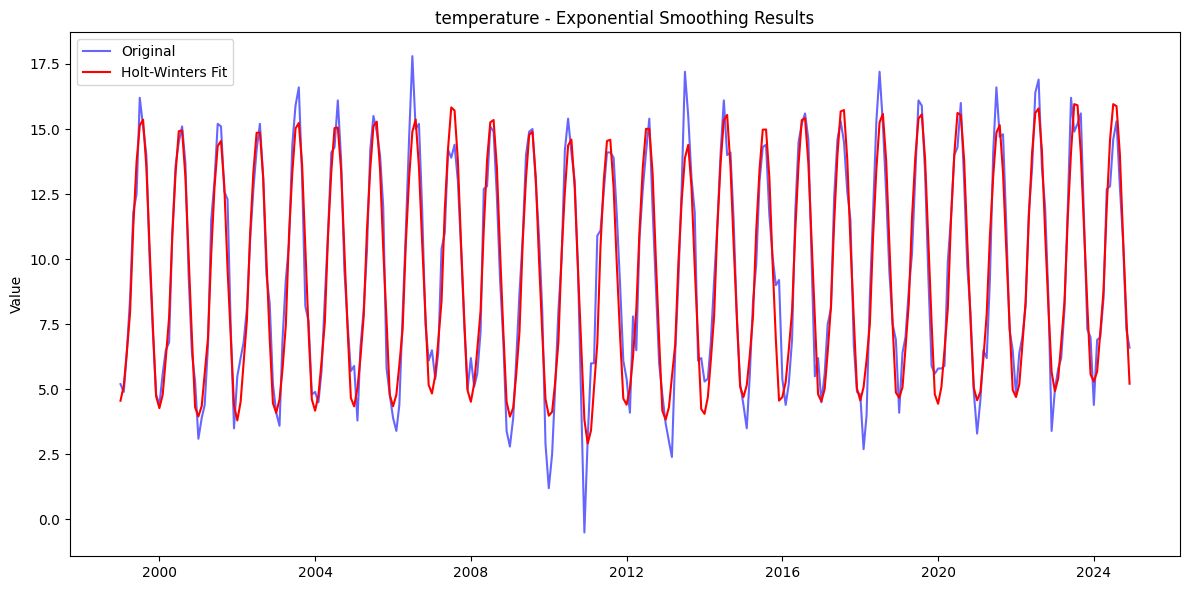


Model Summary for temperature:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                            401.826
Optimized:                         True   AIC                            110.941
Trend:                         Additive   BIC                            170.829
Seasonal:                      Additive   AICC                           113.276
Seasonal Periods:                    12   Date:                 Sun, 09 Mar 2025
Box-Cox:                          False   Time:                         17:53:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1197205                alpha               

/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


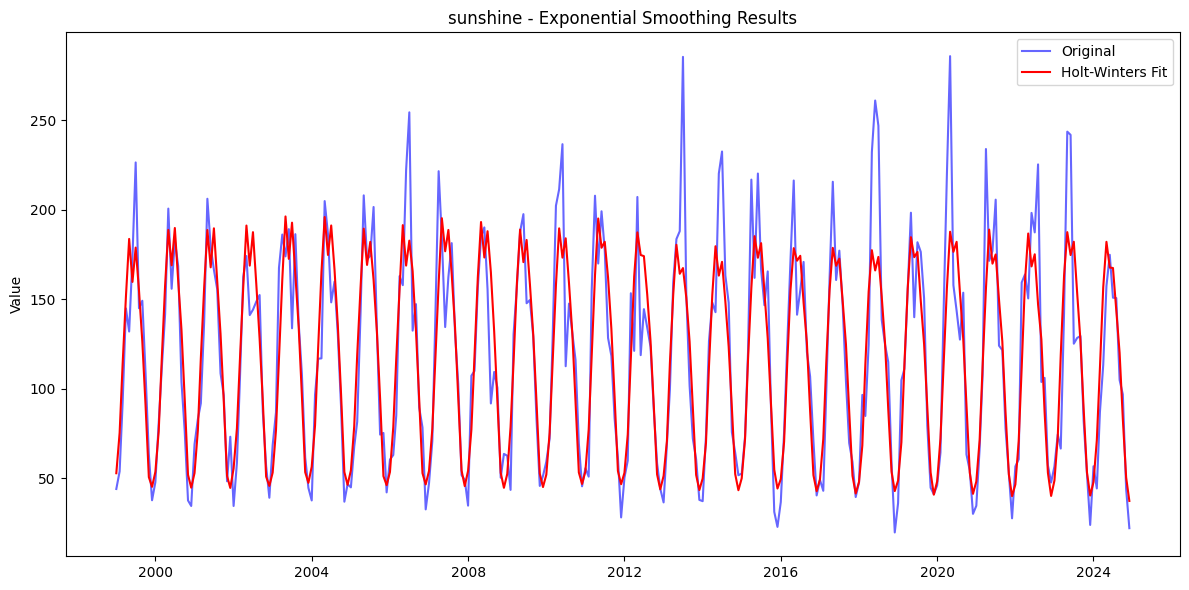


Model Summary for sunshine:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                     None   No. Observations:                  312
Model:             ExponentialSmoothing   SSE                         225901.767
Optimized:                         True   AIC                           2086.474
Trend:                         Additive   BIC                           2146.362
Seasonal:                Multiplicative   AICC                          2088.808
Seasonal Periods:                    12   Date:                 Sun, 09 Mar 2025
Box-Cox:                           True   Time:                         17:53:12
Box-Cox Coeff.:                 0.48356                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0315959                alpha                 T

In [25]:

def plot_holtwinters_results(original_series, fitted_values, feature_name):
    """
    Properly aligned plotting function for Holt-Winters results
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot original data with datetime index
    ax.plot(original_series.index, 
            original_series.values, 
            label='Original', 
            color='blue', 
            alpha=0.6)
    
    # Plot fitted values using SAME datetime index
    ax.plot(fitted_values.index, 
            fitted_values.values, 
            label='Holt-Winters Fit', 
            color='red', 
            linewidth=1.5)
    
    # Format date axis
    # ax.xaxis.set_major_locator(YearLocator(2))
    # ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    # plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    ax.set_title(f'{feature_name} - Exponential Smoothing Results')
    ax.set_ylabel('Value')
    ax.legend()
    plt.tight_layout()
    plt.show()

def apply_exponential_smoothing(series, feature_name):
    """Robust Holt-Winters fitting with zero handling and auto-config"""
    
    # 1. Zero/Negative value handling
    min_positive = series[series > 0].min()
    epsilon = min_positive * 0.001  # 0.1% of smallest positive value
    
    # Apply minimal adjustment only where needed
    adjusted_series = series.where(series > 0, epsilon)
    
    # 2. Auto-configure model parameters
    has_zeros = (series <= 0).any()
    seasonal = 'add' if has_zeros else 'mul'
    use_boxcox = not has_zeros  # Disable Box-Cox if zeros existed originally
    
    # 3. Model configuration
    model = ExponentialSmoothing(
        adjusted_series,
        trend='add',
        seasonal=seasonal,
        seasonal_periods=12,
        use_boxcox=use_boxcox,
        initialization_method='heuristic'
    )
    
    # 4. Fit model
    fit = model.fit()
    
    # 5. Plot results
    plot_holtwinters_results(series, fit.fittedvalues, feature_name)
    
    return fit

# Process and plot each feature
fitted_values_dict = {}
for feature, data in weather_data_df.iterrows():
    ts = pd.Series(data.values.astype(float),
                 index=pd.to_datetime(weather_data_df.columns, format='%b_%Y'))
    print(ts)
    feature_resulting_values = ts
    # Only apply smoothing if it's weather data
    if 'crop_production' not in feature:
        result_model = apply_exponential_smoothing(ts, feature)
        feature_resulting_values = result_model.fittedvalues
        # Print model summary
        print(f"\nModel Summary for {feature}:")
        print(result_model.summary())
    # Store fitted values
    fitted_values_dict[feature] = feature_resulting_values
    
smoothed_weather_data = pd.DataFrame(fitted_values_dict)
print(smoothed_weather_data)


# Filter the smoothed data and crop production based on the crop calendar

In [38]:
# Load the oats calendar
DATA_PATH = '../data/'
oats_calendar = pd.read_csv(DATA_PATH+'oats_calendar.csv', index_col=0)

# Extract relevant months (those with a value of 1 in any row of the calendar)
relevant_months = oats_calendar.columns[oats_calendar.sum(axis=0) > 0].str.lower().tolist()

# Print relevant months for verification
print(f"Relevant months for oats production: {relevant_months}")

# Filter smoothed data based on relevant months
def filter_smoothed_data(smoothed_data, relevant_months):
    # Filter rows where month matches relevant months
    filtered_data = smoothed_data[
        smoothed_data.index.map(lambda x: x.strftime('%b').lower()).isin(relevant_months)
    ]
    return filtered_data

# Assuming smoothed data with datetime columns
filtered_smoothed_data = filter_smoothed_data(smoothed_weather_data, relevant_months)
filtered_smoothed_data.columns.name = 'Date'

# Print filtered data for verification
print("Filtered Smoothed Data (Relevant Months Only):")
print(filtered_smoothed_data.head())

# Load oats production data
production_data = pd.read_csv('../data/wales/wales_oats_production_averaged.csv')

# Map month names to their numerical values
month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

# Calculate the average monthly production for relevant months
production_data['Monthly_Avg'] = production_data['Production'] / len(relevant_months)

# Create a DataFrame with production distributed across relevant months
monthly_production = pd.DataFrame()
for month in relevant_months:
    monthly_production[month] = production_data['Monthly_Avg']

# Add the year column
monthly_production['Year'] = production_data['Year']

# Create a datetime index for monthly production
monthly_production['Date'] = monthly_production.apply(lambda row: pd.to_datetime(f"{int(row['Year'])}-{month_map[relevant_months[0]]}-01"), axis=1)

# However, this will only create dates for the first relevant month. 
# To create dates for all relevant months, you need to iterate over each month and year.

# Correct approach:
monthly_data_list = []
for year in production_data['Year']:
    for month in relevant_months:
        monthly_data_list.append({
            'Date': pd.to_datetime(f"{int(year)}-{month_map[month]}-01"),
            'production': production_data.loc[production_data['Year'] == year, 'Monthly_Avg'].values[0]
        })

# Convert list to DataFrame
monthly_production_df = pd.DataFrame(monthly_data_list)

# Pivot data to match filtered weather format
pivoted_production = monthly_production_df.set_index('Date').pivot_table(index='Date', values='production', aggfunc='sum')

# Print the result for verification
print(pivoted_production.head())

# now merge the two data frames ionto a single master data frame for further processing
# Merge the two DataFrames on the Date index
merged_input_data = pd.merge(filtered_smoothed_data, pivoted_production,
                      left_index=True, right_index=True, how='inner')

# Print the merged DataFrame for verification
print("Merged DataFrame:")
print(merged_input_data.head())

Relevant months for oats production: ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep']
Filtered Smoothed Data (Relevant Months Only):
Date        airfrost_days    rainfall  temperature    sunshine
1999-03-01       4.926350   82.960759     6.396741  113.563809
1999-04-01       2.166160  123.645339     7.941172  151.471772
1999-05-01      -1.447836  117.826824    11.239355  183.650704
1999-06-01      -1.466491   76.629326    13.744790  159.627185
1999-07-01      -0.703351   73.657372    15.139628  178.818574
             production
Date                   
1999-03-01  2509.588571
1999-04-01  2509.588571
1999-05-01  2509.588571
1999-06-01  2509.588571
1999-07-01  2509.588571
Merged DataFrame:
            airfrost_days    rainfall  temperature    sunshine   production
1999-03-01       4.926350   82.960759     6.396741  113.563809  2509.588571
1999-04-01       2.166160  123.645339     7.941172  151.471772  2509.588571
1999-05-01      -1.447836  117.826824    11.239355  183.650704  2509.58857

# Use the output of the smoothing to feed an LSTM model

Epoch 1/100


/Users/mada/.virtualenvs/mada-proj/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.1992 - val_loss: 0.0417
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0880 - val_loss: 0.0563
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0969 - val_loss: 0.0409
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0819 - val_loss: 0.0395
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0933 - val_loss: 0.0385
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0766 - val_loss: 0.0392
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0631 - val_loss: 0.0412
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0822 - val_loss: 0.0407
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0797 - val_loss: 0.0417
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0819 - val_loss: 0.0429
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0695 - val_loss: 0.0436
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0639 - val_loss: 0.0468
Epoch 13/1

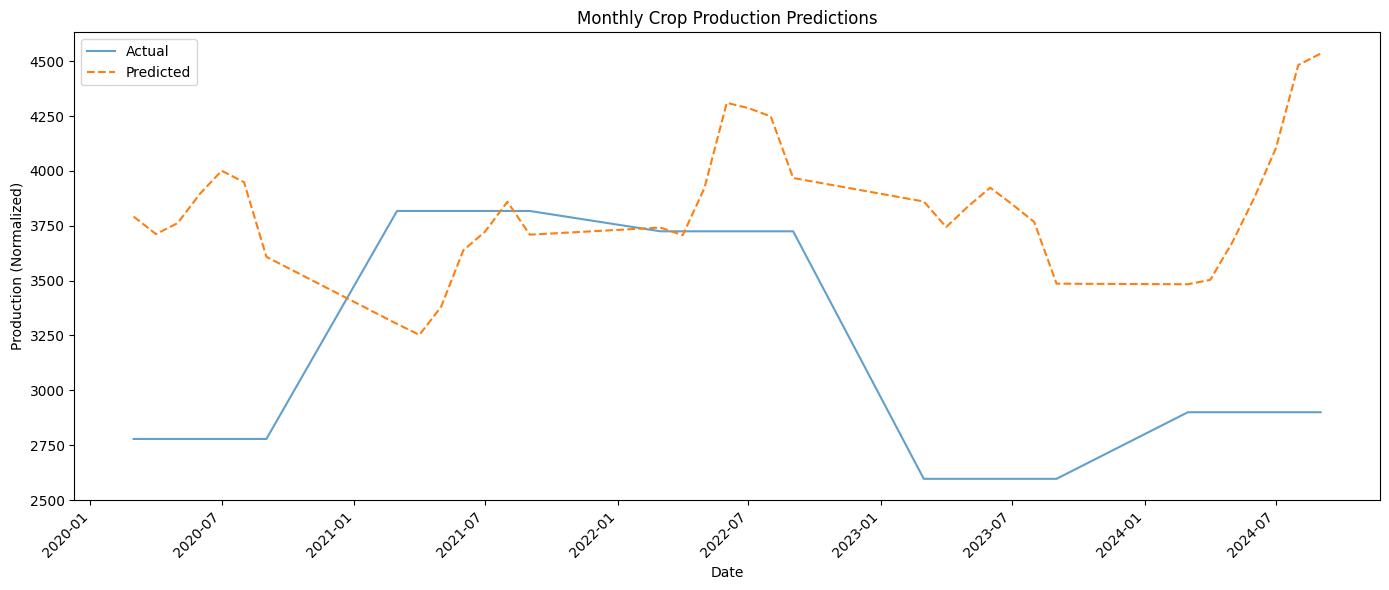

In [39]:
# 2. Prepare sequences for LSTM
def create_monthly_sequences(data, n_steps=12):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data.iloc[i:i+n_steps, :-1].values)  # Climate features
        y.append(data.iloc[i+n_steps, -1])            # Crop production
    return np.array(X), np.array(y)

# Normalize data (excluding datetime index)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_input_data)

# Create sequences using only the number of relevant months of history
X, y = create_monthly_sequences(pd.DataFrame(scaled_data, 
                                           index=merged_input_data.index), 
                              n_steps=len(relevant_months))

# 3. Split data (maintain temporal order)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 4. Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', 
        input_shape=(X_train.shape[1], X_train.shape[2]),
        return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Train model
history = model.fit(X_train, y_train,
                  epochs=100,
                  batch_size=24,
                  validation_data=(X_test, y_test),
                  verbose=1)

# 6. Predict and inverse scaling
def inverse_scale_preds(features, predictions):
    dummy = np.zeros((len(predictions), features.shape[1]+1))
    dummy[:, :-1] = features  # Original climate features
    dummy[:, -1:] = predictions
    return scaler.inverse_transform(dummy)[:, -1]

# Make predictions
test_preds = model.predict(X_test)
test_preds = inverse_scale_preds(X_test[:, -1, :], test_preds)

# Get actual values
y_actual = inverse_scale_preds(X_test[:, -1, :], y_test.reshape(y_test.shape[0],1))# This is needed because the inverse scaling function needs the arrays to be the same shape

# 7. Visualize results with dates
dates = merged_input_data.index[len(relevant_months)+split:]  # Offset by window size + split point

plt.figure(figsize=(14, 6))
plt.plot(dates, y_actual, label='Actual', alpha=0.7)
plt.plot(dates, test_preds, label='Predicted', linestyle='--')
plt.title('Monthly Crop Production Predictions')
plt.xlabel('Date')
plt.ylabel('Production (Normalized)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Group prediction results by year

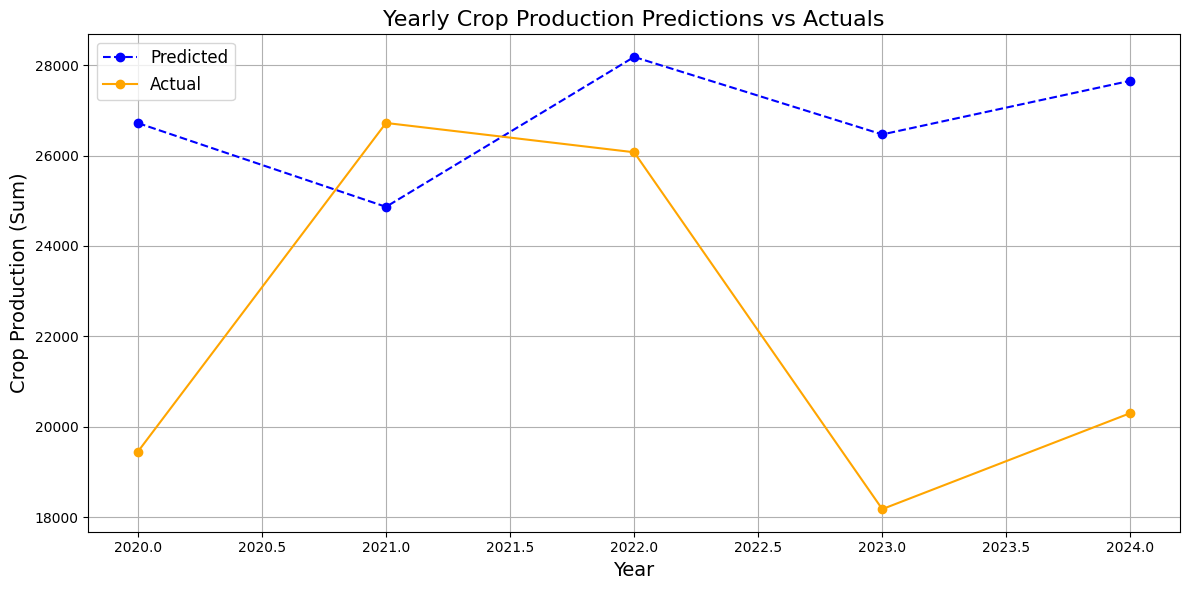

In [41]:
# Create a DataFrame for predictions and actual values (the previous cell MUST have been executed previously)
data = pd.DataFrame({
    'Date': dates,
    'Predicted': test_preds,
    'Actual': y_actual
})

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Roll up to yearly basis by taking the sum for each year
data['Year'] = data['Date'].dt.year

# Roll up to yearly basis by summing only numeric columns
yearly_data = data.groupby('Year')[['Predicted', 'Actual']].sum()

# Plot yearly data
plt.figure(figsize=(12, 6))
plt.plot(yearly_data.index, yearly_data['Predicted'], label='Predicted', marker='o', linestyle='--', color='blue')
plt.plot(yearly_data.index, yearly_data['Actual'], label='Actual', marker='o', linestyle='-', color='orange')

# Add labels, title, and legend
plt.title('Yearly Crop Production Predictions vs Actuals', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Crop Production (Sum)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
